# Preamble

In [12]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl",
              "gridExtra","zoo","RColorBrewer","scales")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }

# to show the plots as svg-graphics in Jupyter
# options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png") 

windowsFonts(Times = windowsFont("Times New Roman"))

'%&%' = function(x,y)paste0(x,y)

# Loading the data

In [13]:
filename = "data.xlsx"

options(warn=-1)
read_excel(filename, sheet = "raw_onset") %>% ncol -> nclmns
read_excel(filename, sheet = "raw_onset", col_types = rep("date",nclmns)) %>%
    gather(epicurve,onset) %>% 
    mutate(number=1:n()) -> df
if (read_excel(filename, sheet = "raw_confirm") %>% ncol==nclmns)
    message("Something wrong with number of columns in Excel file!")
read_excel(filename, sheet = "raw_confirm", col_types = rep("date",nclmns)) %>%
    gather(epicurve,confirmed) %>%
    mutate(number=1:n()) %>%
    left_join(df) %>%
    select(epicurve,onset,confirmed) %>%
    mutate(onset=as.Date(onset), confirmed=as.Date(confirmed)) -> df
options(warn=0)
df %>% tail

Something wrong with number of columns in Excel file!
Joining, by = c("epicurve", "number")


epicurve,onset,confirmed
May07,2018-04-27,2018-05-02
May07,2018-04-30,2018-05-02
May07,2018-04-28,2018-05-03
May07,2018-05-02,2018-05-05
May07,2018-05-03,2018-05-05
May07,2018-05-03,2018-05-05


In [14]:
df %<>%
    mutate(difference=confirmed-onset,
           # if the onset date is unknown, it is assummed to be 5 days prior the confirmation
           difference=ifelse(is.na(onset),5,difference), 
           onset=if_else(is.na(as.numeric(onset)),confirmed-difference,onset)) %>%
    na.omit

# we shift the onset data of the index case to the date of first exposure 
df[which(df$onset=='2018-03-14'),'onset'] = as.Date('2018-03-17')

df %>% head

epicurve,onset,confirmed,difference
Apr01,2018-03-17,2018-03-20,6
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-27,2018-03-29,2
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-25,2018-03-31,6
Apr01,2018-03-26,2018-03-31,5


In [95]:
# total number of records
df %>% nrow

[1] 637

We use Gamma distribution to define generation time distribution $g_t$, Weibull distribution for delay distribution $h_t$ between symptoms onset and lab confirmation

In [96]:
g = function(time) { 
    g_mean = 11.7; g_var = 9.0 # from (Klinkenberg and Nishiura 2011)
    scl = g_var/g_mean
    pgamma(time,shape=g_mean/scl,scale=scl)-pgamma(time-1,shape=g_mean/scl,scale=scl) }

h = function(delta,parms) {
    pweibull(delta,parms[1],parms[2])-pweibull(delta-1,parms[1],parms[2]) }

In [97]:
# using days since index case instead of dates
(mindate = min(df$onset))
(maxdate = max(df$confirmed))
df %<>% 
    mutate(day_onset = unclass(onset)-unclass(mindate),
           day_confirmation = unclass(confirmed)-unclass(mindate))
df %>% head

[1] "2018-03-17"

[1] "2018-05-05"

epicurve,onset,confirmed,difference,day_onset,day_confirmation
Apr01,2018-03-17,2018-03-20,6,0,3
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-27,2018-03-29,2,10,12
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-25,2018-03-31,6,8,14
Apr01,2018-03-26,2018-03-31,5,9,14


In [98]:
# Available epicurves
(all_epicurves = unique(df$epicurve))

[1] "Apr01" "Apr05" "Apr09" "Apr13" "Apr17" "Apr21" "Apr25" "Apr29" "May03"
[10] "May07"

# For example, we first analyse only one epicurve

In [114]:
# last available update
(current_epicurve = all_epicurves %>% rev %>% .[1])

[1] "May07"

In [115]:
(maxDay = max(df$day_confirmation)+7)

[1] 56

In [116]:
df %>% 
    filter(epicurve==current_epicurve) %>% 
    select(-epicurve) -> df_current

Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

df_current %>% 
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_onset) %>%
    count %>%
    rename(day=day_onset) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(i=n) -> Df

df_current %>%
    filter(day_onset>0) %>% #removing index case from fitting
    group_by(day_confirmation) %>%
    count %>%
    rename(day=day_confirmation) %>%
    right_join(Df,by="day") %>%
    mutate(n=ifelse(is.na(n),0,n)) %>%
    rename(c=n) %>%
    select(day,i,c) %>%
    arrange(day) -> Df

Df %>% tail

day,i,c
46,1,4
47,2,1
48,0,0
49,0,3
50,0,0
51,0,0


In [117]:
loglk_four_generations = function(prms) {
    K = prms[3]; R2 = prms[4]; R3 = prms[5]
    
    data.frame(day = Df$day) %>%
        mutate(gt=g(day),ht=h(day,prms[1:2])) -> df_

    #calculating first convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv1_gt=conv))

    #calculating second convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv1_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv2_gt=conv))

    df_ %<>% 
        mutate(ft = (gt+R2*conv1_gt+R2*R3*conv2_gt)/(1+R2+R2*R3)) %>%
        right_join(Df,by="day")
    
    df_ %>%
        filter(ft>0) %>% 
        summarize(loglk = sum(i*log(K*ft)-K*ft-lfactorial(i))) %>% .$loglk -> loglk_onset
    
    #calculating convolution with h
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$ft[1:x]*df_$ht[x:1])) }
    df_ %<>% do(cbind(.,conv_ht=conv))
    
    df_ %>%
        filter(conv_ht>0) %>%
        summarize(loglk = sum(c*log(K*conv_ht)-K*conv_ht-lfactorial(c))) %>% .$loglk -> loglk_confirm
    
    df_current %>% 
        group_by(difference) %>%
        count %>%
        ungroup %>%
        summarize(loglk = sum(n*log(h(difference,prms[1:2])))) %>% .$loglk -> loglk_delay
    
    loglk_delay+loglk_onset+loglk_confirm
}

loglk_three_generations = function(x) { loglk_four_generations(c(x[1:4],0)) }

loglk_two_generations = function(x) { loglk_four_generations(c(x[1:3],0,0)) }

getPrediction = function(prms,ndays) {
    K = prms[3]; 
    R2 = ifelse(length(prms)<4, 0, prms[4]);
    R3 = ifelse(length(prms)<5, 0, prms[5]);
    
    data.frame(day = 0:ndays) %>%
        mutate(gt=g(day),ht=h(day,prms[1:2])) -> df_

    #calculating first convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv1_gt=conv))

    #calculating second convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$conv1_gt[1:x]*df_$gt[x:1])) }
    df_ %<>% do(cbind(.,conv2_gt=conv))
    
    df_ %<>% 
        mutate(ft = gt/(1+R2+R2*R3)+R2*conv1_gt/(1+R2+R2*R3)+R2*R3*conv2_gt/(1+R2+R2*R3))
    
    #calculating third convolution
    conv = c()
    for (x in 1:nrow(df_)) {
        conv = c(conv,sum(df_$ft[1:x]*df_$ht[x:1])) }
    df_ %<>% do(cbind(.,conv_ht=conv))
    
    df_ %<>% 
        mutate(lambda_i = K*ft, lambda_c = K*conv_ht) %>%
        left_join(Df,by="day")
    
    df_
}

getDelay = function(prms) {
    df_current %>% 
        mutate(delta = day_confirmation-day_onset) %>%
        group_by(delta) %>%
        count %>%
        ungroup -> df_

    df_ %>% 
        right_join(data.frame(delta=1:max(df_$delta)+1),by="delta") %>%
        mutate(n = ifelse(is.na(n),0,n), ht = h(delta,prms)) %>%
        mutate(freq = n/sum(n)) %>%
        return
}

In [118]:
# test
init = c(2,4,100,1.2,.5)
loglk_four_generations(init)

[1] -404.7871

In [122]:
fourth_generation = TRUE
third_generation = TRUE

pars = init

if (fourth_generation) { 
    options(warn=-1)
    sol = optim(pars,loglk_four_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,5),
                hessian=TRUE)
    options(warn=0)
    pars = sol$par }

if (pars[length(pars)]==0) fourth_generation = FALSE

# first we assume that there are three generations
if (!fourth_generation) { 
    options(warn=-1)
    sol = optim(pars[1:4],loglk_three_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,4),
                hessian=TRUE)
    options(warn=0)
    pars = sol$par }

if (pars[length(pars)]==0) third_generation = FALSE

if (!third_generation) { 
    options(warn=-1)
    sol = optim(pars[1:3],loglk_two_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,3),
                hessian=TRUE)
    options(warn=0) 
    pars = sol$par }

sol

pars

-38.675172604,8.456356547,-0.002537504,-0.105533758,-0.15939533
8.456356547,-24.322283778,0.005533394,-1.666620122,-1.83858209
-0.002537504,0.005533394,-0.018564407,0.003909278,0.01035811
-0.105533758,-1.666620122,0.003909278,-26.041306569,-17.93784125
-0.159395327,-1.838582087,0.010358114,-17.937841250,-37.74407877


[1]   2.233357   4.729510 106.862948   1.208505   1.006198

In [123]:
# Obtained Weibull distribution mean and variance
c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))

[1] 4.188861 3.932269

In [124]:
getPrediction(pars,maxDay) -> dfMLE 
dfMLE %>% tail(10)

,day,gt,ht,conv1_gt,conv2_gt,ft,conv_ht,lambda_i,lambda_c,i,c
48,47,1.016631e-12,0,7.306608e-06,0.0111453643,0.0039601502,0.013927243,0.42319333,1.4883063,2,1
49,48,3.750333e-13,0,3.754830e-06,0.0080295144,0.0028524996,0.011450626,0.30482652,1.2236477,0,0
50,49,1.375566e-13,0,1.903984e-06,0.0056666779,0.0020128344,0.009200645,0.21509742,0.9832080,0,3
51,50,5.007106e-14,0,9.531768e-07,0.0039208687,0.0013925851,0.007230084,0.14881575,0.7726281,0,0
52,51,1.809664e-14,0,4.713522e-07,0.0026619415,0.0009453866,0.005560589,0.10102680,0.5942210,0,0
53,52,6.550316e-15,0,2.303512e-07,0.0017746162,0.0006302241,0.004188562,0.06734760,0.4476020,NA,NA
54,53,2.331468e-15,0,1.113031e-07,0.0011625410,0.0004128422,0.003092311,0.04411754,0.3304534,NA,NA
55,54,8.881784e-16,0,5.319656e-08,0.0007488601,0.0002659291,0.002239102,0.02841797,0.2392770,NA,NA
56,55,3.330669e-16,0,2.515916e-08,0.0004746308,0.0001685440,0.001591200,0.01801111,0.1700404,NA,NA
57,56,0.000000e+00,0,1.177911e-08,0.0002961648,0.0001051684,0.001110485,0.01123860,0.1186697,NA,NA


Warning message:
"Removed 5 rows containing missing values (geom_bar)."Warning message:
"Removed 5 rows containing missing values (geom_bar)."

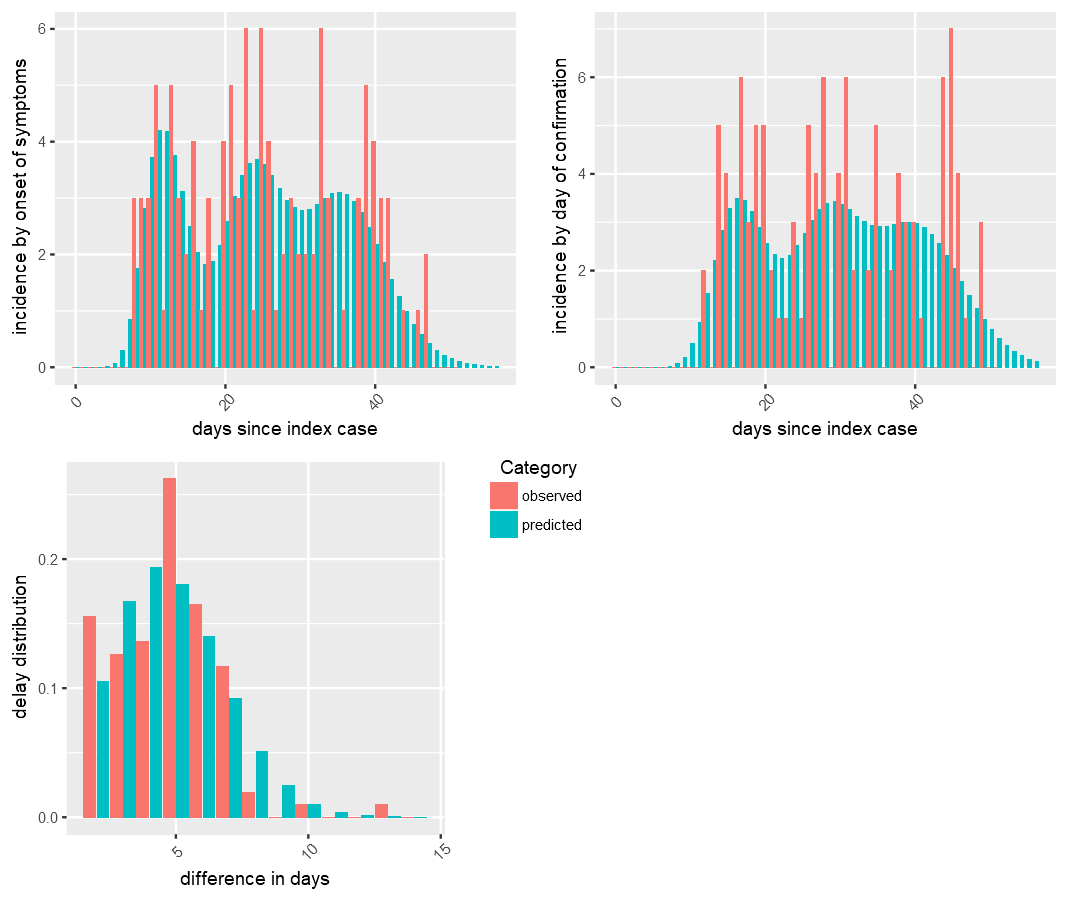

In [125]:
options(repr.plot.width=9,repr.plot.height=7.5)
xmax = max(dfMLE$day)

dfMLE %>%
    select(one_of("day","lambda_i","i")) %>%
    rename(pred=lambda_i,obs=i) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by onset of symptoms",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_onset

dfMLE %>%
    select(one_of("day","lambda_c","c")) %>%
    rename(pred=lambda_c,obs=c) %>%
    gather(Category,Count,-day) %>%
    mutate(Category=factor(Category,levels=c("pred","obs") %>% rev)) %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        coord_cartesian(xlim=c(0,xmax)) +
        guides(fill=F) +
        labs(y="incidence by day of confirmation",x="days since index case") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_confirmation

getDelay(pars[1:2]) %>%
    select(delta,ht,freq) %>%
    rename(predicted=ht,observed=freq) %>%
    gather(Category,Count,-delta) %>%
    mutate(Category=factor(Category,levels=c("predicted","observed") %>% rev)) %>%
    ggplot(aes(x=delta)) +
        geom_bar(aes(y=Count,fill=Category),stat="identity",position=position_dodge(1)) +
        guides(fill=guide_legend(title.hjust = 0.5)) +
        labs(y="delay distribution",x="difference in days") +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(1.25,.9),
              plot.margin = unit(c(.5,4,.5,.5),"lines")
             ) -> plt_delay

grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), ggplotGrob(plt_delay),
                 widths=c(1,1), heights=c(1,1), nrow=2, ncol=2)

# Constructing profile-based confidence intervals

In [126]:
(vc = solve(-sol$hessian))
(sd = sqrt(diag(vc)))

0.0280012450,0.009796219,-0.001213103,-0.0004909395,-0.0003624566
0.0097962188,0.044757286,0.010875210,-0.0020431144,-0.0012476052
-0.0012131025,0.010875210,53.878081569,-0.0036072865,0.0159755034
-0.0004909395,-0.002043114,-0.003607286,0.0571829975,-0.0270755637
-0.0003624566,-0.001247605,0.015975503,-0.0270755637,0.0394285484


[1] 0.1673357 0.2115592 7.3401690 0.2391297 0.1985662

In [127]:
# sampling
sample = 1e3
hess_sam = MASS::mvrnorm(n=sample, mu=sol$par, 
                     Sigma=solve(-sol$hessian),
                     tol=1e-06, empirical=FALSE, EISPACK=FALSE)
hess_sam %>% as.data.frame -> df_hess

clmn_nms = c("h1","h2","K")
if (length(sol$par)>3) clmn_nms = c(clmn_nms,"R2")
if (length(sol$par)>4) clmn_nms = c(clmn_nms,"R3")
colnames(df_hess) = clmn_nms
df_hess %>% head

h1,h2,K,R2,R3
2.307229,4.746261,111.2950,0.8576985,1.2265949
2.017885,4.808011,105.6241,1.2297507,0.9539003
2.218977,4.551402,109.9967,0.9421805,1.5330325
2.377390,5.271913,107.8939,1.0384945,1.1971793
2.275252,4.535958,127.6541,1.5978565,0.8475827
2.120999,4.698178,105.3899,0.7101338,1.0952053


In [128]:
# selecting 95% middle range
data.frame(
    h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
    h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
    K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K
) -> df_perturb
    
if(length(sol$par)>3) 
    df_perturb %<>% cbind(data.frame(R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2))
if(length(sol$par)>4) 
    df_perturb %<>% cbind(data.frame(R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3))

df_perturb %>% head

h1,h2,K,R2,R3
2.307229,4.746261,111.2950,0.8576985,1.2265949
2.017885,4.808011,105.6241,1.2297507,0.9539003
2.218977,4.551402,109.9967,0.9421805,1.1971793
2.377390,4.535958,107.8939,1.0384945,0.8475827
2.275252,4.698178,105.3899,1.5978565,1.0952053
2.120999,4.838020,118.2299,0.9650966,0.9683923


In [129]:
# prediction
res = NULL
for (i in 1:nrow(df_perturb)) {
    res = rbind(res,getPrediction(df_perturb[i,] %>% as.numeric,maxDay) %>% select(day,contains("lambda"))) }

In [130]:
res %>% 
    group_by(day) %>%
    summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
              c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result

Warning message:
"Removed 5 rows containing missing values (geom_bar)."Warning message:
"Removed 5 rows containing missing values (geom_bar)."

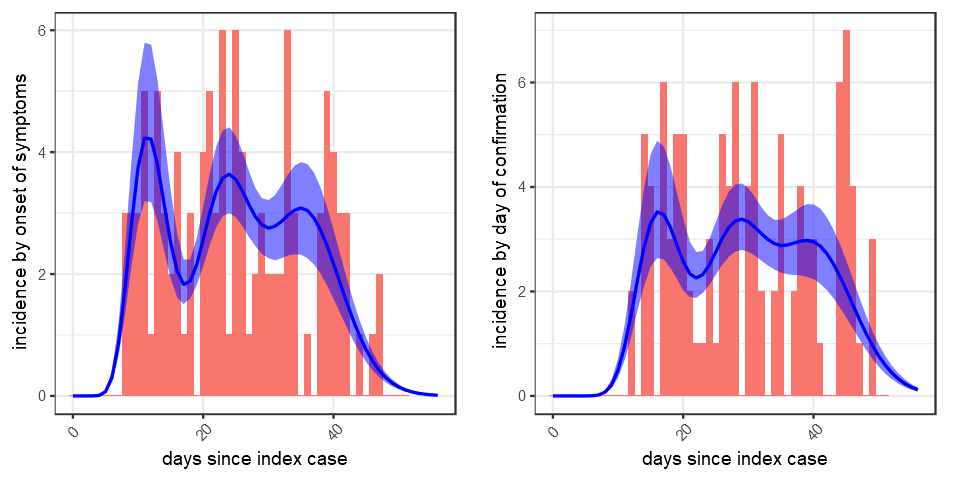

In [131]:
options(repr.plot.width=8,repr.plot.height=4)
xmax = max(dfMLE$day)

dfMLE %>%
    ggplot(aes(x=day)) +
        geom_bar(aes(y=i,fill="red"),stat="identity",position=position_dodge(1)) +
        geom_ribbon(data=result,aes(ymin=c025_i,ymax=c975_i),fill="blue",alpha=.5) +
        geom_line(data=result,aes(y=median_i),size=.7,color="blue") +
        coord_cartesian(xlim=c(0,maxDay)) +
        guides(fill=F) +
        labs(y="incidence by onset of symptoms",x="days since index case") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_onset

dfMLE %>%
    ggplot(aes(x=day,fill="red")) +
        geom_bar(aes(y=c),stat="identity",position=position_dodge(1)) +
        geom_ribbon(data=result,aes(ymin=c025_c,ymax=c975_c),fill="blue",alpha=.5) +
        geom_line(data=result,aes(y=median_c),size=.7,color="blue") +
        coord_cartesian(xlim=c(0,maxDay)) +
        guides(fill=F) +
        labs(y="incidence by day of confirmation",x="days since index case") +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              strip.background = element_rect(colour="white", fill="white"),
              legend.position=c(.2,.87),
              plot.margin = unit(c(.5,1,.5,.5),"lines"),
              legend.direction="horizontal") -> plt_confirmation

p = grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), 
                 widths=c(1,1), heights=c(1), nrow=1, ncol=2)

# Performing the analysis for all available epicurves

In [133]:
final = NULL
pars_final = NULL
fourth_generation = TRUE
third_generation = TRUE

for (current_epicurve in rev(unique(df$epicurve))) { 
    message(current_epicurve)
    # initial parameter values used in optim function
    pars = c(2,4,50,1,.5)
    
    df %>% 
        filter(epicurve==current_epicurve) %>% 
        select(-epicurve) -> df_current

    Df = data.frame(day=0:(unclass(as.Date('2018'%&%current_epicurve,"%Y%b%d"))-unclass(as.Date('2018-03-17'))))

    df_current %>% 
        filter(day_onset>0) %>% #removing index case
        group_by(day_onset) %>%
        count %>%
        rename(day=day_onset) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(i=n) -> Df

    df_current %>%
        filter(day_onset>0) %>% #removing index case
        group_by(day_confirmation) %>%
        count %>%
        rename(day=day_confirmation) %>%
        right_join(Df,by="day") %>%
        mutate(n=ifelse(is.na(n),0,n)) %>%
        rename(c=n) %>%
        select(day,i,c) %>%
        arrange(day) -> Df
    
    if (fourth_generation) {
        options(warn=-1)
        sol = optim(pars,loglk_four_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,5),
                    hessian=TRUE)
        options(warn=0)

        pars = sol$par }
    
    if (pars[length(pars)]==0) fourth_generation = FALSE
    
    if (!fourth_generation) {
        options(warn=-1)
        sol = optim(pars[1:4],loglk_three_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,4),
                    hessian=TRUE)
        options(warn=0)

        pars = sol$par }

    if (pars[length(pars)]==0) third_generation = FALSE

    if (!third_generation) { 
        options(warn=-1)
        sol = optim(pars[1:3],loglk_two_generations,method="L-BFGS-B",control=list(fnscale=-1),lower=rep(0,3),
                    hessian=TRUE)
        options(warn=0) 

        pars = sol$par }
    
    # Weibull distribution mean and variance
    pars_h = c(pars[2]*gamma(1+1/pars[1]),pars[2]^2*(gamma(1+2/pars[1])-(gamma(1+1/pars[1]))^2))
    
    # Maximum likelihood estimates (MLE)
    dfMLE = getPrediction(pars,maxDay) %>% rename(`MLE_i`=`lambda_i`,`MLE_c`=`lambda_c`)
    
    # RMSE
    getPrediction(pars,maxDay) %>%
        na.omit %>%
        mutate(epsilon_i = (lambda_i-i), epsilon_c = (lambda_c-c)) %>%
        summarize(rmse_i = sqrt(sum(epsilon_i^2)/n()),rmse_c = sqrt(sum(epsilon_c^2)/n())) %>% as.numeric -> rmse
    
    npars = length(pars)
    output = data.frame(t(c(pars_h,pars,sol$value,2*(npars-sol$value),rmse)))
    clmn_nms = c("mean_h","var_h","par1_h","par2_h","K")
    if (third_generation) clmn_nms = c(clmn_nms,"R2")
    if (fourth_generation) clmn_nms = c(clmn_nms,"R3")
    clmn_nms = c(clmn_nms,"loglk","AIC","rmse_i","rmse_c")
    colnames(output) = clmn_nms

    print(output) 
    
    output %>%
        gather(parameter,estimate) %>%
        mutate(epicurve=current_epicurve) %>%
        rbind(pars_final) -> pars_final
    
    sample = 1e3
    hess_sam = MASS::mvrnorm(n=sample, mu=sol$par, 
                         Sigma=solve(-sol$hessian),
                         tol=1e-06, empirical=FALSE, EISPACK=FALSE)
    hess_sam %>% as.data.frame -> df_hess

    clmn_nms = c("h1","h2","K")
    if (length(sol$par)>3) clmn_nms = c(clmn_nms,"R2")
    if (length(sol$par)>4) clmn_nms = c(clmn_nms,"R3")
    colnames(df_hess) = clmn_nms
    
    data.frame(
        h1=filter(df_hess,h1 > quantile(h1, 0.025) & h1 < quantile(h1, 0.975))$h1,
        h2=filter(df_hess,h2 > quantile(h2, 0.025) & h2 < quantile(h2, 0.975))$h2,
        K=filter(df_hess,K > quantile(K, 0.025) & K < quantile(K, 0.975))$K
    ) -> df_perturb

    if(length(sol$par)>3) 
        df_perturb %<>% cbind(data.frame(R2=filter(df_hess,R2 > quantile(R2, 0.025) & R2 < quantile(R2, 0.975))$R2))
    if(length(sol$par)>4) 
        df_perturb %<>% cbind(data.frame(R3=filter(df_hess,R3 > quantile(R3, 0.025) & R3 < quantile(R3, 0.975))$R3))
    
    res = NULL
    for (i in 1:nrow(df_perturb)) {
        res = rbind(res,getPrediction(df_perturb[i,] %>% as.numeric,maxDay) %>% select(day,contains("lambda")))
    }
    
    res %>% 
    group_by(day) %>%
    summarize(c025_i=quantile(lambda_i,0.025),median_i=median(lambda_i),c975_i=quantile(lambda_i,0.975),
              c025_c=quantile(lambda_c,0.025),median_c=median(lambda_c),c975_c=quantile(lambda_c,0.975)) -> result
    
    result %>% 
        mutate(epicurve=current_epicurve) %>%
        left_join(Df,by="day") %>%
        left_join(dfMLE %>% select(one_of("day","MLE_i","MLE_c")),by="day") %>%
        rbind(final) -> final
}

May07


    mean_h    var_h   par1_h  par2_h        K       R2       R3     loglk
1 4.188808 3.932184 2.233352 4.72945 106.8651 1.208452 1.006189 -388.4918
       AIC   rmse_i   rmse_c
1 786.9837 1.444368 1.817581


May03


    mean_h    var_h par1_h   par2_h        K       R2        R3    loglk
1 4.256681 3.904619 2.2827 4.805234 105.9881 1.211313 0.9713265 -372.948
       AIC   rmse_i   rmse_c
1 755.8961 1.483565 1.851855


Apr29


    mean_h    var_h   par1_h   par2_h        K       R2        R3     loglk
1 4.134011 3.326785 2.415988 4.662799 88.15343 1.394332 0.3404667 -304.2928
       AIC   rmse_i   rmse_c
1 618.5856 1.322711 1.595797


Apr25


    mean_h    var_h   par1_h   par2_h        K      R2        R3     loglk
1 4.113223 2.740391 2.677215 4.626645 88.48431 1.35074 0.3857624 -279.9106
       AIC   rmse_i  rmse_c
1 569.8213 1.327416 1.62549


Apr21


    mean_h    var_h   par1_h   par2_h        K      R2     loglk      AIC
1 4.170666 2.821014 2.675333 4.691367 74.07156 1.40762 -244.8963 497.7926
    rmse_i   rmse_c
1 1.237728 1.635791


Apr17


    mean_h    var_h   par1_h   par2_h        K       R2     loglk      AIC
1 4.139312 2.854171 2.635619 4.658345 69.53227 1.235932 -216.5043 441.0085
    rmse_i   rmse_c
1 1.386478 1.577228


Apr13


    mean_h    var_h   par1_h   par2_h        K        R2     loglk      AIC
1 4.034125 3.038345 2.473014 4.547877 57.62557 0.7940415 -169.0011 346.0022
    rmse_i   rmse_c
1 1.324904 1.424916


Apr09


    mean_h    var_h  par1_h   par2_h        K     loglk     AIC   rmse_i
1 4.260009 3.723151 2.34618 4.807342 34.76968 -124.4105 254.821 1.094393
    rmse_c
1 1.318751


Apr05


    mean_h   var_h   par1_h  par2_h        K     loglk      AIC    rmse_i
1 4.211082 3.80494 2.288208 4.75364 28.44927 -93.60308 193.2062 0.8486471
    rmse_c
1 1.365003


Apr01


    mean_h    var_h   par1_h   par2_h        K     loglk      AIC   rmse_i
1 3.893677 3.109383 2.346589 4.393932 17.43019 -51.35994 108.7199 1.143207
    rmse_c
1 1.076107


# Output that is further used to generate Table 1

In [134]:
pars_final %>% 
    spread(parameter,estimate) %>% 
    select(epicurve,mean_h,var_h,par1_h,par2_h,K,loglk,AIC,rmse_i,rmse_c)

epicurve,mean_h,var_h,par1_h,par2_h,K,loglk,AIC,rmse_i,rmse_c
Apr01,3.893677,3.109383,2.346589,4.393932,17.43019,-51.35994,108.7199,1.1432066,1.076107
Apr05,4.211082,3.804940,2.288208,4.753640,28.44927,-93.60308,193.2062,0.8486471,1.365003
Apr09,4.260009,3.723151,2.346180,4.807342,34.76968,-124.41048,254.8210,1.0943927,1.318751
Apr13,4.034125,3.038345,2.473014,4.547877,57.62557,-169.00110,346.0022,1.3249035,1.424916
Apr17,4.139312,2.854171,2.635619,4.658345,69.53227,-216.50426,441.0085,1.3864776,1.577228
Apr21,4.170666,2.821014,2.675333,4.691367,74.07156,-244.89629,497.7926,1.2377283,1.635791
Apr25,4.113223,2.740391,2.677215,4.626645,88.48431,-279.91064,569.8213,1.3274160,1.625490
Apr29,4.134011,3.326785,2.415988,4.662799,88.15343,-304.29278,618.5856,1.3227114,1.595797
May03,4.256681,3.904619,2.282700,4.805234,105.98810,-372.94805,755.8961,1.4835655,1.851855
May07,4.188808,3.932184,2.233352,4.729450,106.86515,-388.49184,786.9837,1.4443683,1.817581


# Generating Figure 2

[1] "May07"

Warning message:
"Removed 5 rows containing missing values (geom_bar)."Warning message:
"Removed 5 rows containing missing values (geom_bar)."

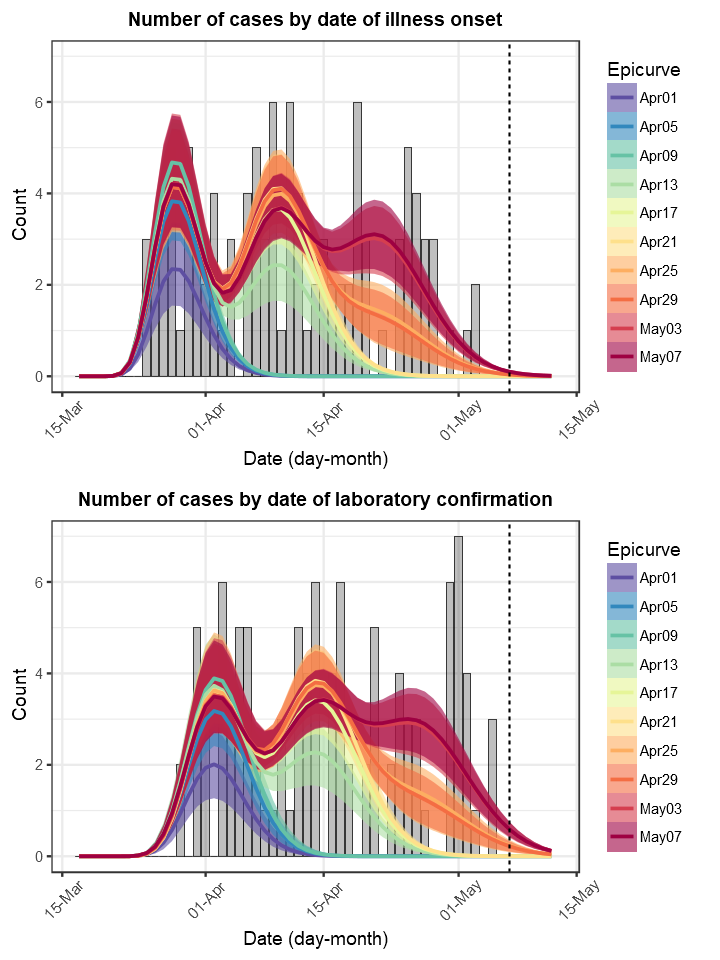

In [135]:
options(repr.plot.width=6,repr.plot.height=8)
final %<>% mutate(date = as.Date('2018-03-17')+day)

(background_epicurve = rev(all_epicurves)[1])

final %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(data=filter(final,epicurve==background_epicurve),
                 aes(y=i),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.25,size=.15) +
        geom_ribbon(aes(ymin=c025_i,ymax=c975_i),alpha=.6,size=0) +
        geom_line(aes(y=MLE_i),size=.8) +
        geom_vline(xintercept=filter(final,epicurve==background_epicurve) %>% na.omit %>% { max(.$date) },
                   size=.45, linetype="dashed") +
        coord_cartesian(ylim=c(0,7)) +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        labs(y="Count", x="Date (day-month)",
             title="Number of cases by date of illness onset",
             color="Epicurve", fill="Epicurve") +
        scale_x_date(labels = date_format("%d-%b")) +
        theme_bw() +
        theme(
              axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,.5,.5),"lines")) -> plt_onset

final %>%
    ggplot(aes(x=date,group=epicurve,color=epicurve,fill=epicurve)) +
        geom_bar(data=filter(final,epicurve==background_epicurve),
                 aes(y=c),fill="black",color="black",stat="identity",
                 position=position_dodge(1),alpha=.25,size=.15) +
        geom_ribbon(aes(ymin=c025_c,ymax=c975_c),alpha=.6,size=0) +
        geom_line(aes(y=MLE_c),size=.8) +
        geom_vline(xintercept=filter(final,epicurve==background_epicurve) %>% na.omit %>% { max(.$date) },
                   size=.45, linetype="dashed") +
        scale_color_brewer(palette="Spectral",direction=-1) +
        scale_fill_brewer(palette="Spectral",direction=-1) +
        scale_x_date(labels = date_format("%d-%b")) +
        labs(y="Count", x="Date (day-month)",
             title="Number of cases by date of laboratory confirmation",
             color="Epicurve", fill="Epicurve") +
        theme_bw() + 
        theme(axis.text.x = element_text(angle = 45, hjust = .5, vjust=0.5),
              strip.text.x = element_blank(),
              panel.grid.minor.x = element_blank(),
              plot.title = element_text(size=11, hjust = 0.5, face="bold"),
              strip.background = element_rect(colour="white", fill="white"),
              plot.margin = unit(c(.5,1,.5,.5),"lines")) -> plt_confirmation

grid.arrange(ggplotGrob(plt_onset), ggplotGrob(plt_confirmation), widths=c(1), heights=c(1,1), nrow=2, ncol=1)